In [133]:
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u 
from astropy.table import Table

from snewpy.neutrino import Flavor, MassHierarchy, MixingParameters
from snewpy.models import Nakazato_2013
from snewpy.models.ccsn import Fornax_2022
from snewpy.models.ccsn import Bollig_2016
from snewpy.models.ccsn import Sukhbold_2015
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes
from asteria import set_rcparams
from asteria.simulation import Simulation


set_rcparams()
%matplotlib inline

C:\Users\sanya\AppData\Local\Temp\ipykernel_13360\3737798815.py:11: FutureWarning: snewpy.models.Nakazato_2013 is moved to snewpy.models.ccsn.Nakazato_2013
  from snewpy.models import Nakazato_2013


In [10]:
Nakazato_2013.param

{'progenitor_mass': <Quantity [13., 20., 30., 50.] solMass>,
 'revival_time': <Quantity [  0., 100., 200., 300.] ms>,
 'metallicity': [0.02, 0.004],
 'eos': ['LS220', 'shen', 'togashi']}

In [107]:
Sukhbold_2015.param

{'progenitor_mass': <Quantity [27. ,  9.6] solMass>, 'eos': ['LS220', 'SFHo']}

In [4]:
model = Nakazato_2013(progenitor_mass=13.0*u.solMass,revival_time=300*u.ms,metallicity=.02,eos='shen')

In [6]:
highz_models = list(params for params in Nakazato_2013.get_param_combinations())

In [108]:
sukh_models = list(params for params in Sukhbold_2015.get_param_combinations())

In [109]:
sukh_models

[{'progenitor_mass': <Quantity 27. solMass>, 'eos': 'LS220'},
 {'progenitor_mass': <Quantity 27. solMass>, 'eos': 'SFHo'},
 {'progenitor_mass': <Quantity 9.6 solMass>, 'eos': 'LS220'},
 {'progenitor_mass': <Quantity 9.6 solMass>, 'eos': 'SFHo'}]

In [11]:
model_a = {'name': 'Nakazato_2013',
           'param': highz_models[0]
          }

In [16]:
energies = np.linspace(0,100,201) * u.MeV
times = model.get_time()

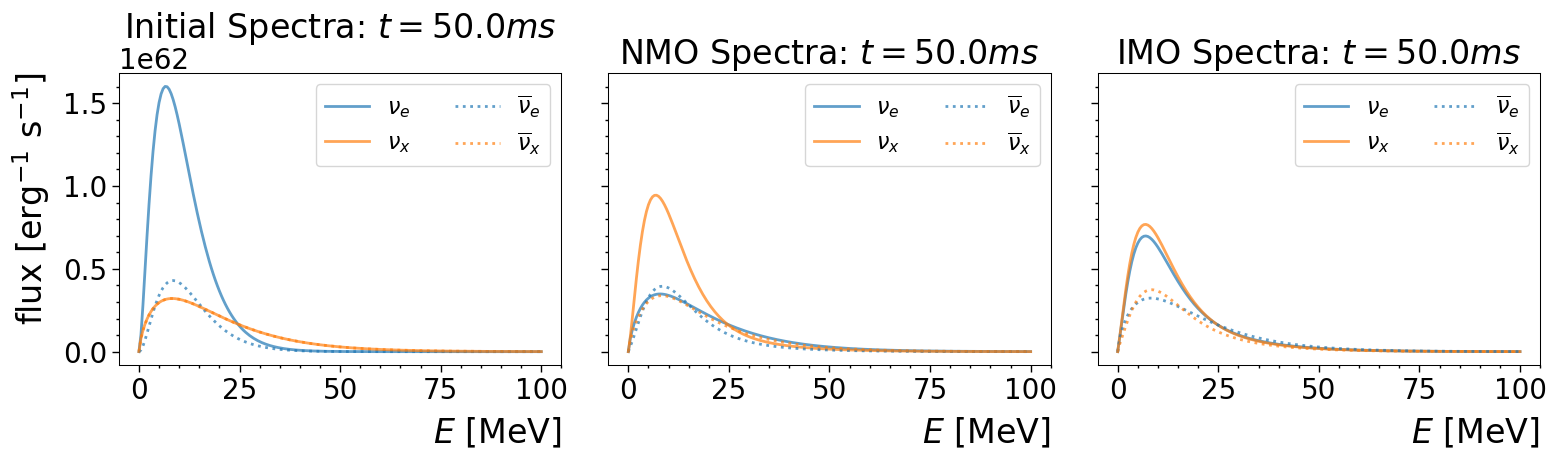

In [46]:
t=50*u.ms
nmo=AdiabaticMSW()
imo=AdiabaticMSW(mh=MassHierarchy.INVERTED)

ispec = model.get_initial_spectra(t, energies) 
ospec_nmo = model.get_transformed_spectra(t, energies,nmo)
ospec_imo = model.get_transformed_spectra(t, energies,imo)


fig, axes = plt.subplots(1,3, figsize=(16,5), sharex=True, sharey=True, tight_layout=True)

for i, spec in enumerate([ispec, ospec_nmo,ospec_imo]):
    ax = axes[i]
    for flavor in Flavor:
        ax.plot(energies, spec[flavor],
                label=flavor.to_tex(),
                color='C0' if flavor.is_electron else 'C1',
                ls='-' if flavor.is_neutrino else ':', lw=2,
                alpha=0.7)

    ax.set(xlabel=r'$E$ [{}]'.format(energies.unit),
           title=('Initial Spectra: $t = {:.1f}$'.format(t) if i==0 
                  else ('NMO Spectra: $t = {:.1f}$'.format(t) if i==1 
                        else 'IMO Spectra: $t = {:.1f}$'.format(t))))
    ax.grid()
    ax.legend(loc='upper right', ncol=2, fontsize=16)

ax = axes[0]
ax.set(ylabel=r'flux [erg$^{-1}$ s$^{-1}$]')

fig.tight_layout();

In [145]:
mass = []
for i,m in enumerate(Fornax_2022.param['progenitor_mass'][::25]):
    mass.append(m)

forn_models = list(params for params in Fornax_2022.get_param_combinations() if params['progenitor_mass'] in mass)
forn_models

[{'progenitor_mass': <Quantity 9. solMass>},
 {'progenitor_mass': <Quantity 12.54 solMass>},
 {'progenitor_mass': <Quantity 14.01 solMass>},
 {'progenitor_mass': <Quantity 18.04 solMass>}]

In [161]:
def run_sim(modell):
    sim_i = Simulation(model=model_a,
                     distance=10 * u.kpc, 
                     Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                     tmin=-1*u.s,  tmax=10*u.s,    dt=1*u.ms,
                     mixing_scheme='AdiabaticMSW',
                     hierarchy='inverted')


    sim = Simulation(model=model_a,
                     distance=10 * u.kpc, 
                     Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                     tmin=-1*u.s, tmax=10*u.s, dt=1*u.ms,
                     )


    sim_n = Simulation(model=model_a,
                     distance=10 * u.kpc, 
                     Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                     tmin=-1*u.s,tmax=10*u.s, dt=1*u.ms,
                     mixing_scheme='AdiabaticMSW',
                     hierarchy='normal')
    sim.run()
    sim_i.run()
    sim_n.run()
    return sim,sim_n,sim_i

In [147]:
labels=['normal','nmo','imo']
for i,mo in enumerate(forn_models):
    model_a = {'name': 'Fornax_2022',
               'param': forn_models[i]
              }

    sim,sim_n,sim_i=run_sim(model_a)
    for j,simm in enumerate([sim, sim_n,sim_i]): 
        with open("Fornax_M={}_mix={}.pkl".format(forn_models[i]['progenitor_mass'].value,
                                                                 labels[j]), 'wb') as f:
            pickle.dump(simm, f)

Expect a reduction in performance and increase in simulation run times.
Expect a reduction in performance and increase in simulation run times.
Expect a reduction in performance and increase in simulation run times.
Expect a reduction in performance and increase in simulation run times.
Expect a reduction in performance and increase in simulation run times.
Expect a reduction in performance and increase in simulation run times.
Expect a reduction in performance and increase in simulation run times.
Expect a reduction in performance and increase in simulation run times.
Expect a reduction in performance and increase in simulation run times.
Expect a reduction in performance and increase in simulation run times.
Expect a reduction in performance and increase in simulation run times.
Expect a reduction in performance and increase in simulation run times.


In [33]:
labels=['normal','nmo','imo']
for i,mo in enumerate(highz_models):
    model_a = {'name': 'Nakazato_2013',
               'param': highz_models[i]
              }

    sim,sim_n,sim_i=run_sim(model_a)
    for j,simm in enumerate([sim, sim_n,sim_i]): 
        with open("Nakazato_eos={}_z={}_M={}_trev={}_mix={}.pkl".format(highz_models[i]['eos'], 
                                                                 highz_models[i]['metallicity'],
                                                                 highz_models[i]['progenitor_mass'].value,
                                                                 highz_models[i]['revival_time'].value,
                                                                 labels[j]), 'wb') as f:
            pickle.dump(simm, f)

nakazato-shen-z0.004-t_rev100ms-s13.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.02-t_rev200ms-s13.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.004-t_rev200ms-s13.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.004-t_rev300ms-s13.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.02-t_rev100ms-s20.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.02-t_rev200ms-s20.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.004-t_rev200ms-s20.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.02-t_rev300ms-s20.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.004-t_rev300ms-s20.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-LS220-BH-z0.004-s30.0.fits:   0%|          | 0.00/368k [00:00<?, ?iB/s]

nakazato-shen-BH-z0.004-s30.0.fits:   0%|          | 0.00/698k [00:00<?, ?iB/s]

nakazato-togashi-BH-z0.004-s30.0.fits:   0%|          | 0.00/551k [00:00<?, ?iB/s]

nakazato-shen-z0.02-t_rev100ms-s30.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.02-t_rev200ms-s30.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.02-t_rev300ms-s30.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.02-t_rev100ms-s50.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.004-t_rev100ms-s50.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.02-t_rev200ms-s50.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.004-t_rev200ms-s50.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.02-t_rev300ms-s50.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

nakazato-shen-z0.004-t_rev300ms-s50.0.fits:   0%|          | 0.00/36.6k [00:00<?, ?iB/s]

In [110]:
labels=['normal','nmo','imo']
for i,mo in enumerate(sukh_models):
    model_a = {'name': 'Sukhbold_2015',
               'param': sukh_models[i]
              }

    sim_i = Simulation(model=model_a,
                     distance=10 * u.kpc, 
                     Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                     tmin=-1*u.s,  tmax=10*u.s,    dt=1*u.ms,
                     mixing_scheme='AdiabaticMSW',
                     hierarchy='inverted')


    sim = Simulation(model=model_a,
                     distance=10 * u.kpc, 
                     Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                     tmin=-1*u.s, tmax=10*u.s, dt=1*u.ms,
                     )


    sim_n = Simulation(model=model_a,
                     distance=10 * u.kpc, 
                     Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                     tmin=-1*u.s,tmax=10*u.s, dt=1*u.ms,
                     mixing_scheme='AdiabaticMSW',
                     hierarchy='normal')
    sim.run()
    sim_i.run()
    sim_n.run()
    for j,simm in enumerate([sim, sim_n,sim_i]): 
        with open("Sukhbold_eos={}_M={}_mix={}.pkl".format(sukh_models[i]['eos'], 
                                                                 sukh_models[i]['progenitor_mass'].value,
                                                                 labels[j]), 'wb') as f:
            pickle.dump(simm, f)

sukhbold-LS220-s27.0.fits:   0%|          | 0.00/782k [00:00<?, ?iB/s]

C:\Users\sanya\miniconda3\lib\site-packages\snewpy\models\base.py:302: RuntimeWarning: divide by zero encountered in log
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
C:\Users\sanya\miniconda3\lib\site-packages\snewpy\models\base.py:302: RuntimeWarning: invalid value encountered in subtract
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
C:\Users\sanya\miniconda3\lib\site-packages\snewpy\models\base.py:303: RuntimeWarning: divide by zero encountered in divide
  - loggamma(1+a) + a*np.log(E) - (1+a)*(E/Ea)) / (u.erg * u.s)


sukhbold-SFHo-s27.0.fits:   0%|          | 0.00/579k [00:00<?, ?iB/s]

sukhbold-LS220-z9.6.fits:   0%|          | 0.00/619k [00:00<?, ?iB/s]

sukhbold-SFHo-z9.6.fits:   0%|          | 0.00/706k [00:00<?, ?iB/s]

In [93]:
z4_t300_models = list(params for params in Nakazato_2013.get_param_combinations() if params['metallicity'] == 0.004 
                      and params['revival_time'].value==300)

In [94]:
z4_t300_models

[{'progenitor_mass': <Quantity 13. solMass>,
  'revival_time': <Quantity 300. ms>,
  'metallicity': 0.004,
  'eos': 'shen'},
 {'progenitor_mass': <Quantity 20. solMass>,
  'revival_time': <Quantity 300. ms>,
  'metallicity': 0.004,
  'eos': 'shen'},
 {'progenitor_mass': <Quantity 50. solMass>,
  'revival_time': <Quantity 300. ms>,
  'metallicity': 0.004,
  'eos': 'shen'}]

In [81]:
z2_t100_mods=[[],[],[]]
z2_t200_mods=[[],[],[]]
z2_t300_mods=[[],[],[]]
labels=['normal','nmo','imo']
models2=[z2_t100_models,z2_t200_models,z2_t300_models]
for j,simm in enumerate([sim, sim_n,sim_i]):
    for k,modd in enumerate([z2_t100_mods,z2_t200_mods,z2_t300_mods]):
        for i,mode in enumerate(models2[k]):
            with open("Nakazato_eos={}_z={}_M={}_trev={}_mix={}.pkl".format(mode['eos'], 
                                                                     mode['metallicity'],
                                                                     mode['progenitor_mass'].value,
                                                                     mode['revival_time'].value,
                                                                     labels[j]), 'rb') as f:
                mod=pickle.load(f)
            modd[j].append(mod)
z2_t100_mods=np.array(z2_t100_mods)
z2_t200_mods=np.array(z2_t200_mods)
z2_t300_mods=np.array(z2_t300_mods)

In [78]:
np.shape(z2_t300_mods)

(3, 4)

Text(0.5, 0.98, 'Nakazato, EOS=Shen, z=.02')

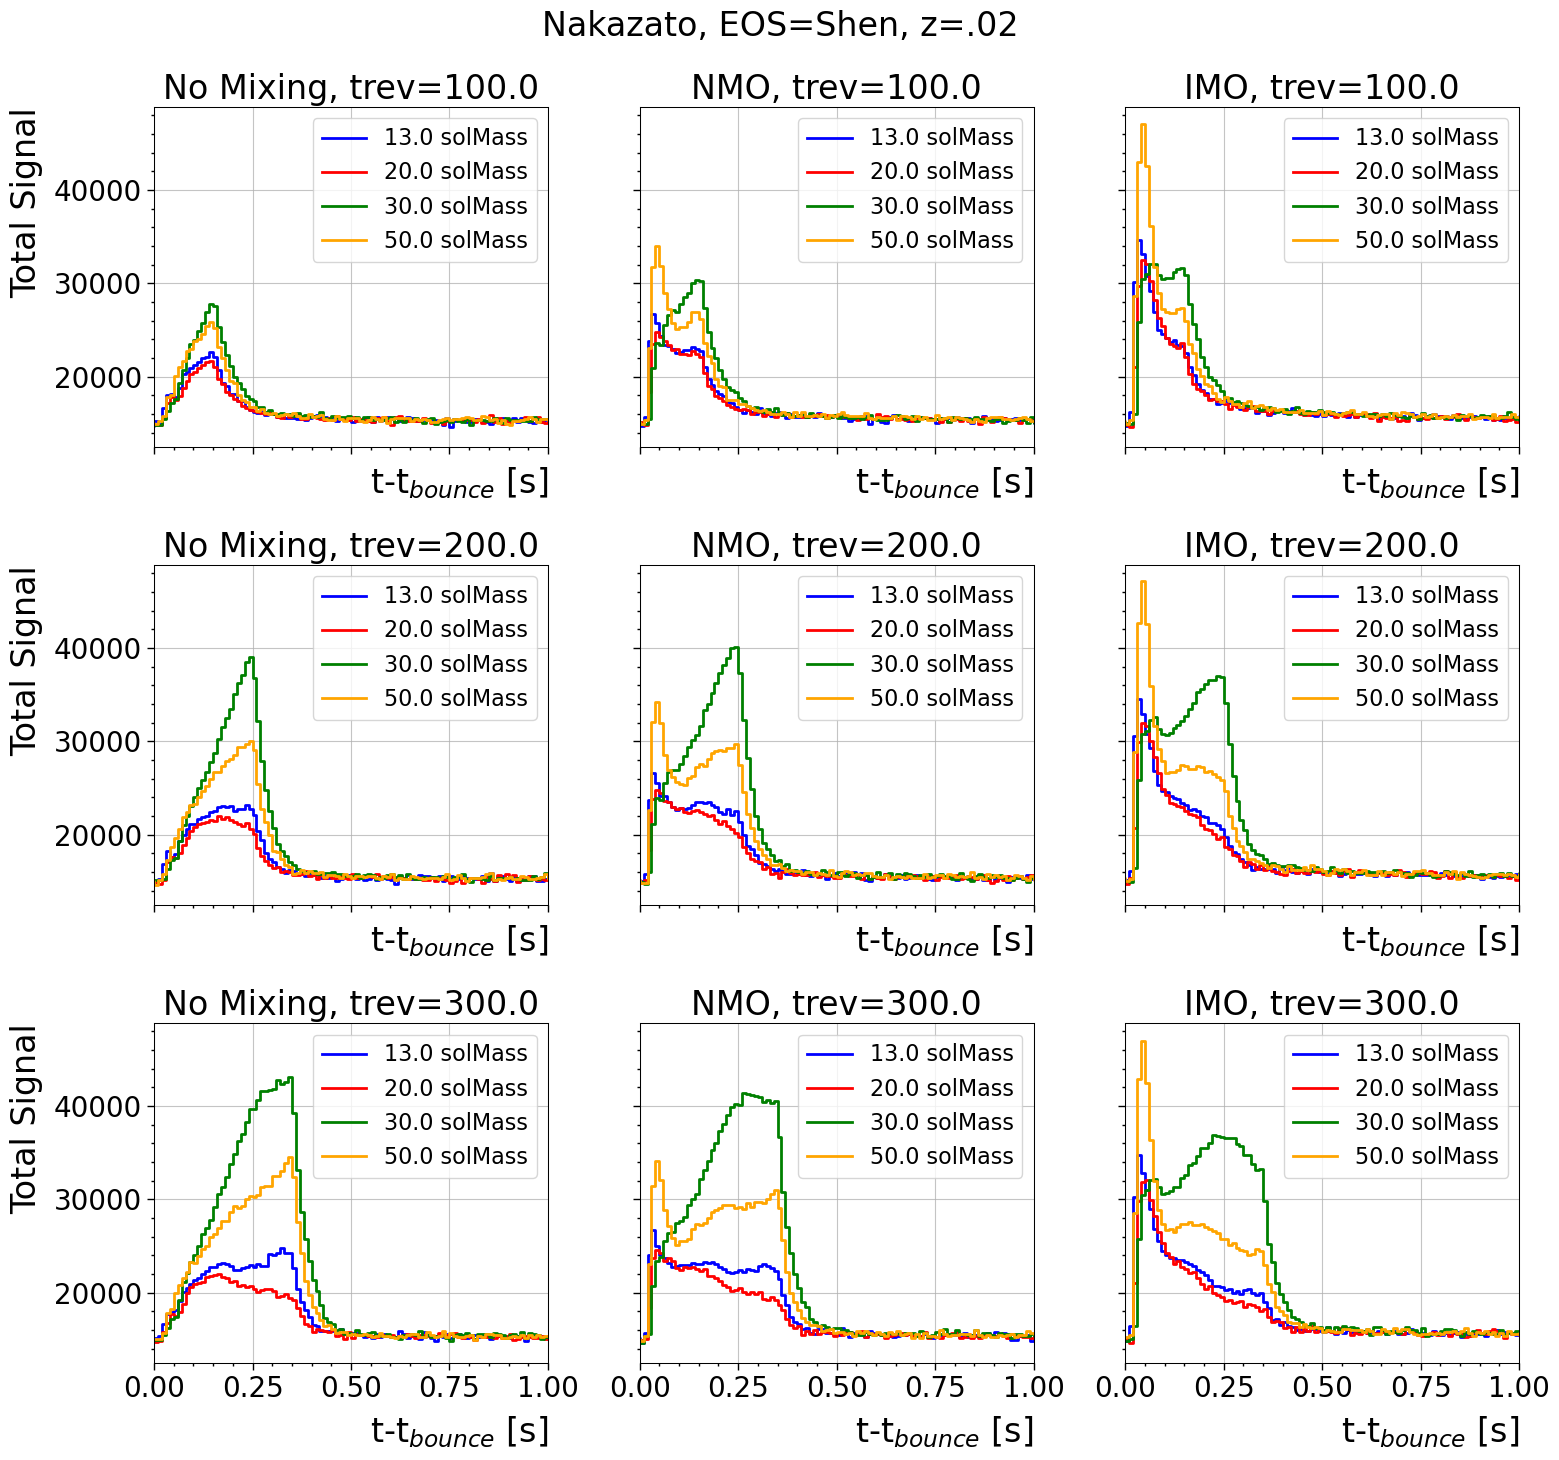

In [82]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
fig, axes = plt.subplots(3,3, figsize=(16,15), sharex=True, sharey=True, tight_layout=True)
dt = 0.01 * u.s
colors=['blue','red','green','orange']

for k,mods in enumerate([z2_t100_mods,z2_t200_mods,z2_t300_mods]):
    for i in range(np.shape(mods)[0]):
        ax=axes[k,i]
        for j,simm in enumerate(mods[i,:]):
            simm.rebin_result(dt)
            t, hits = simm.detector_signal(dt)
            bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
            ax.step(t, hits+bg, where='post', label=models2[k][j]['progenitor_mass'], lw=2,color=colors[j])
        ax.legend()
        ax.set(xlim=(0, 1),xlabel=r'$E$ [{}]'.format(energies.unit),
            title=('No Mixing, trev={}'.format(models2[k][j]['revival_time'].value) if i==0 
                    else ('NMO, trev={}'.format(models2[k][j]['revival_time'].value) if i==1 
                        else 'IMO, trev={}'.format(models2[k][j]['revival_time'].value))))
        ax.set_xlabel(r't-t$_{bounce}$ [s]')
    axes[k,0].set_ylabel(fr'Total Signal')

fig.suptitle('Nakazato, EOS=Shen, z=.02')

Text(0.5, 0.98, 'Nakazato, EOS=Shen, z=.02')

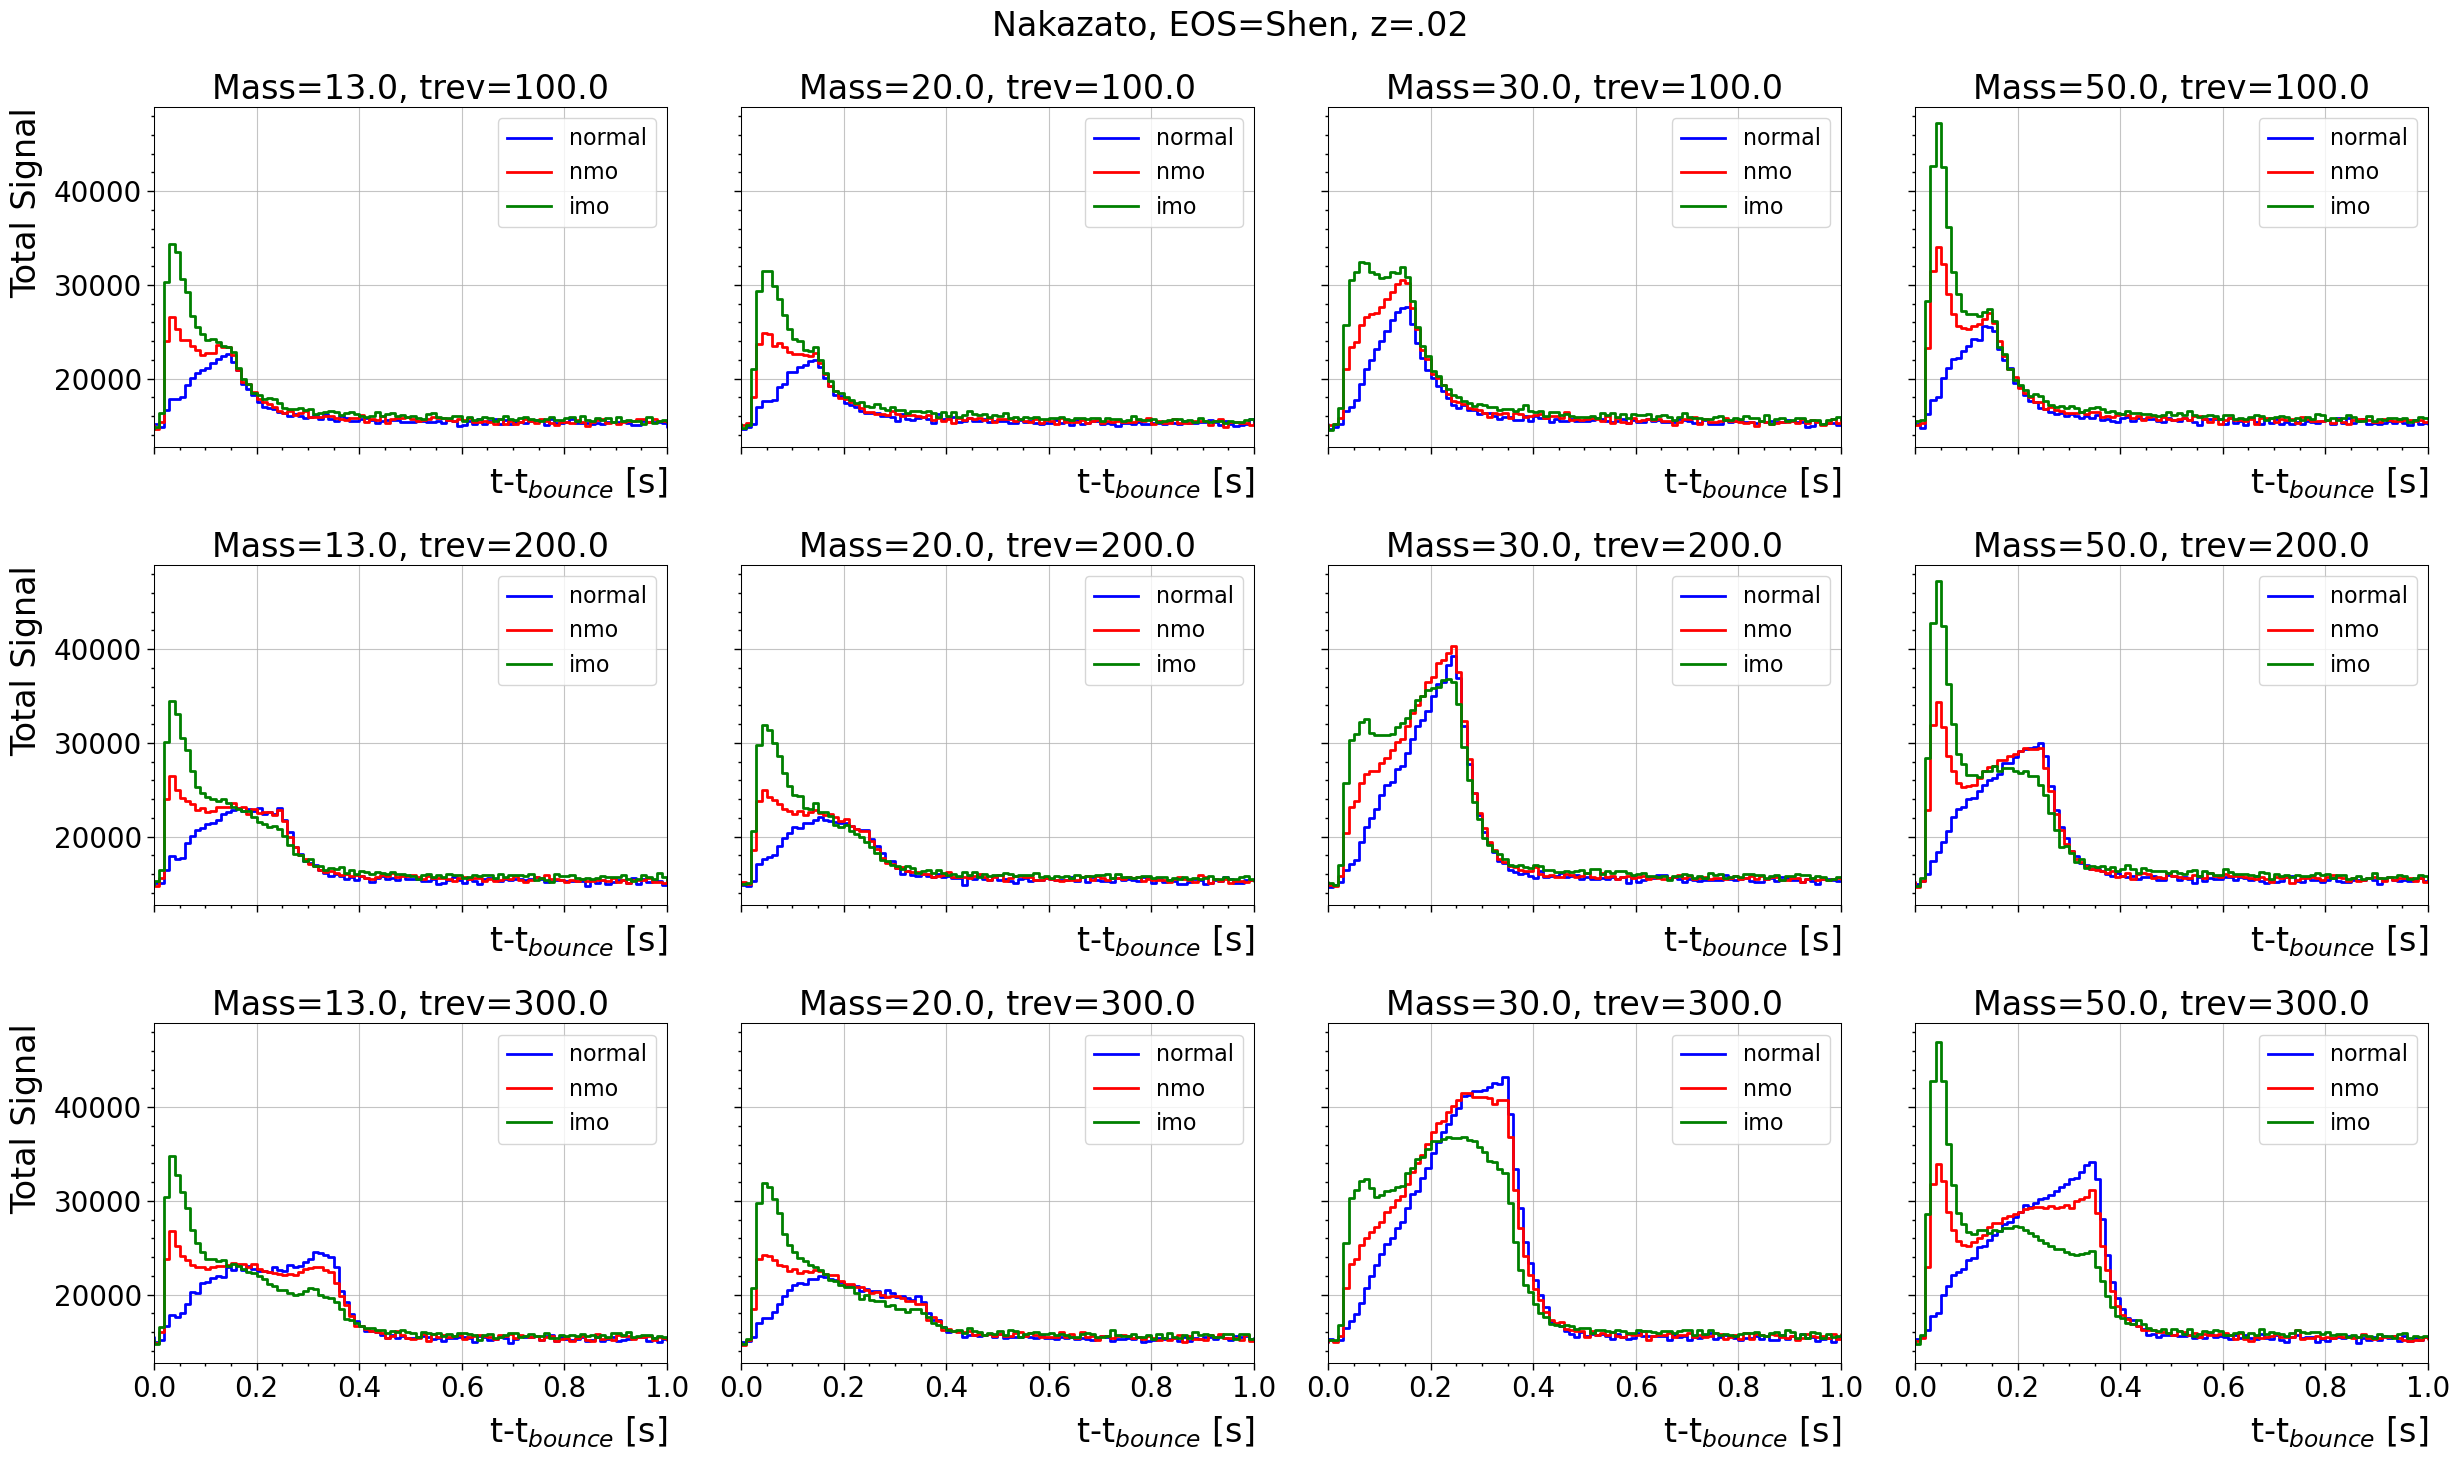

In [166]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
fig, axes = plt.subplots(3,4, figsize=(25,15), sharex=True, sharey=True, tight_layout=True)
dt = 0.01 * u.s
colors=['blue','red','green','orange']

for k,mods in enumerate([z2_t100_mods,z2_t200_mods,z2_t300_mods]):
    for i in range(np.shape(mods)[1]):
        ax=axes[k,i]
        for j,simm in enumerate(mods[:,i]):
            simm.rebin_result(dt)
            t, hits = simm.detector_signal(dt)
            bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
            ax.step(t, hits+bg, where='post', label=labels[j], lw=2,color=colors[j])
        ax.legend()
        m=models2[k][i]['progenitor_mass'].value
        trev=models2[k][i]['revival_time'].value
        ax.set(xlim=(0, 1),xlabel=r'$E$ [{}]'.format(energies.unit),
            title=('Mass={}, trev={}'.format(m,trev) if i==0 
                    else ('Mass={}, trev={}'.format(m,trev) if i==1 
                        else 'Mass={}, trev={}'.format(m,trev))))
        ax.set_xlabel(r't-t$_{bounce}$ [s]')
    axes[k,0].set_ylabel(fr'Total Signal')

fig.suptitle('Nakazato, EOS=Shen, z=.02')

In [96]:
z4_t100_mods=[[],[],[]]
z4_t200_mods=[[],[],[]]
z4_t300_mods=[[],[],[]]
labels=['normal','nmo','imo']
models4=[z4_t100_models,z4_t200_models,z4_t300_models]
for j,simm in enumerate([sim, sim_n,sim_i]):
    for k,modd in enumerate([z4_t100_mods,z4_t200_mods,z4_t300_mods]):
        for i,mode in enumerate(models4[k]):
            with open("Nakazato_eos={}_z={}_M={}_trev={}_mix={}.pkl".format(mode['eos'], 
                                                                     mode['metallicity'],
                                                                     mode['progenitor_mass'].value,
                                                                     mode['revival_time'].value,
                                                                     labels[j]), 'rb') as f:
                mod=pickle.load(f)
            modd[j].append(mod)
z4_t100_mods=np.array(z4_t100_mods)
z4_t200_mods=np.array(z4_t200_mods)
z4_t300_mods=np.array(z4_t300_mods)

Text(0.5, 0.98, 'Nakazato, EOS=Shen, z=.004')

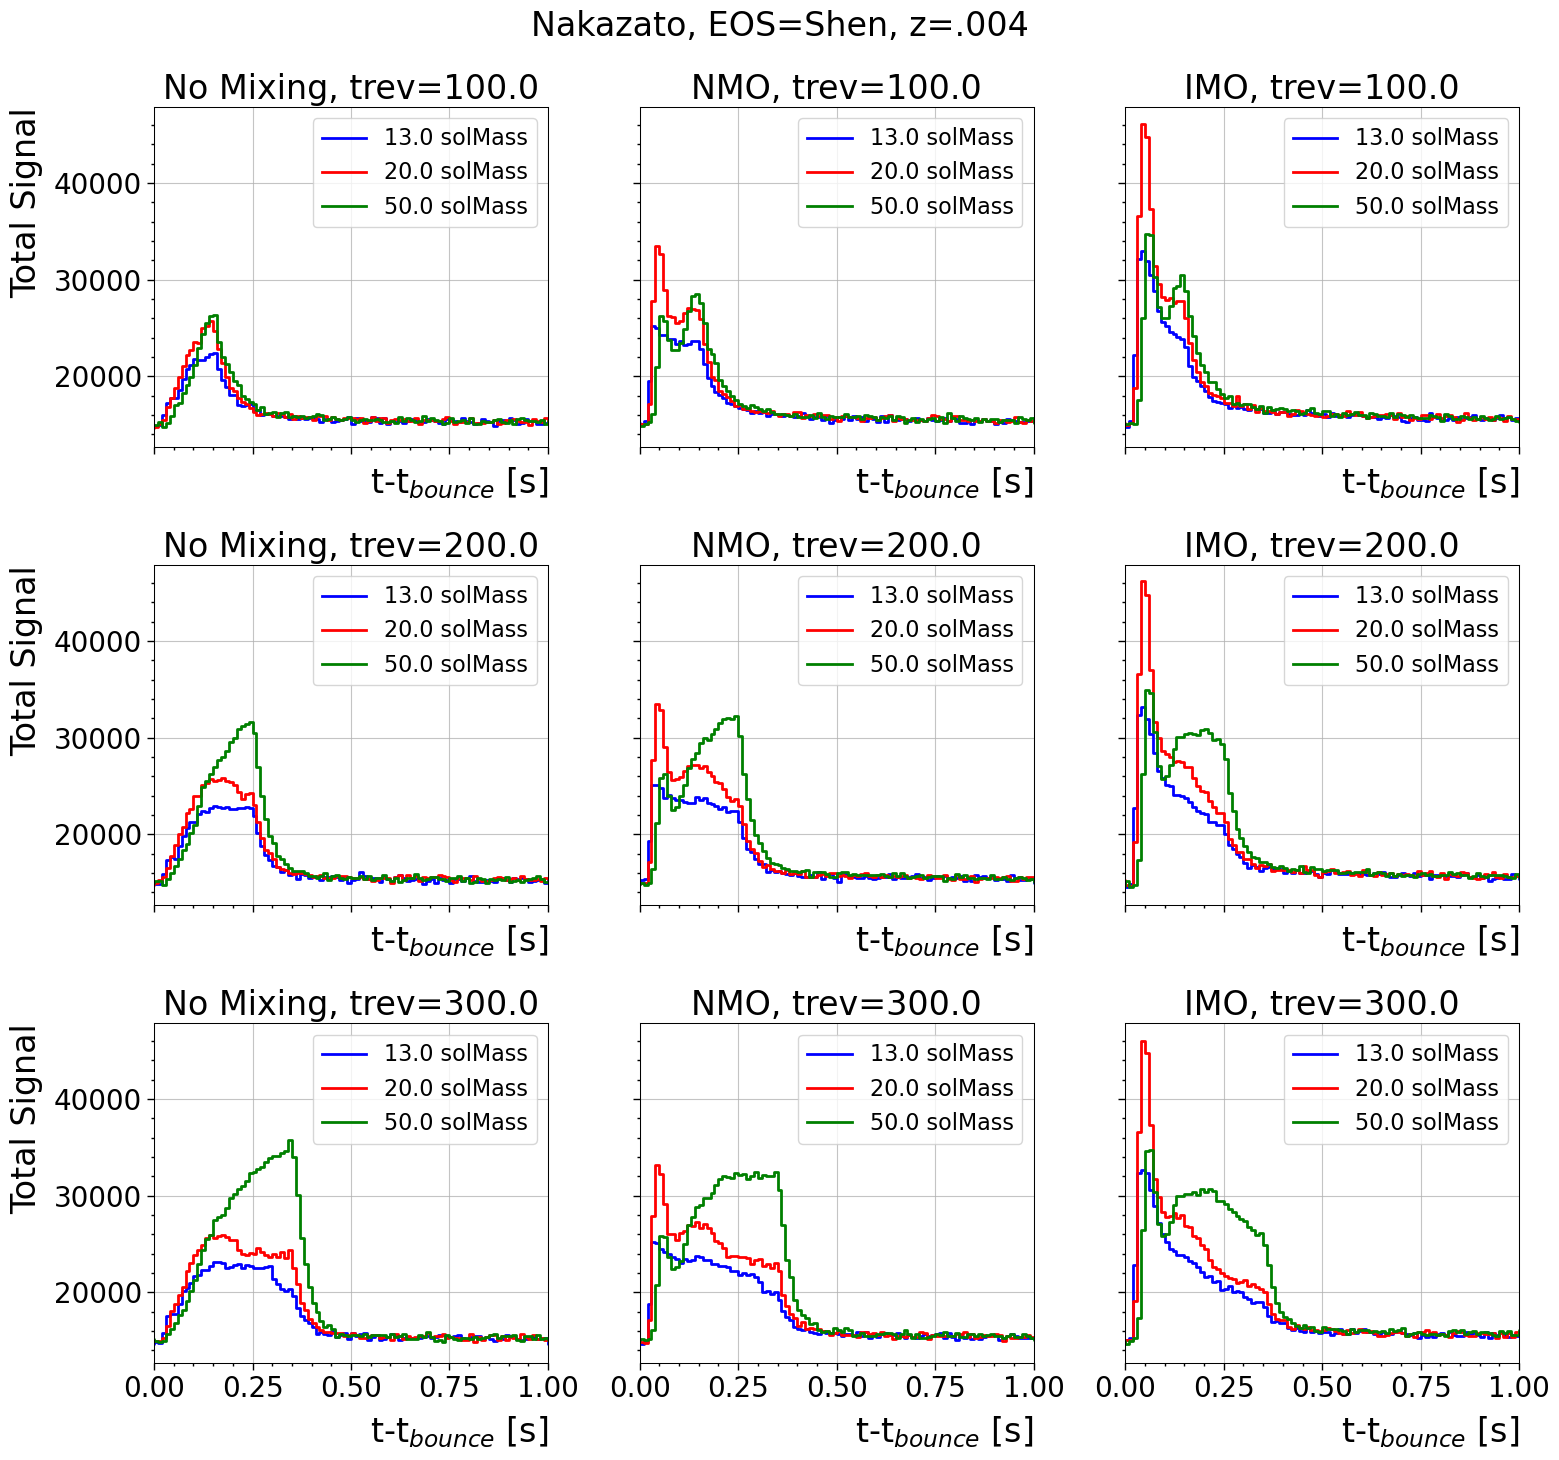

In [97]:
fig, axes = plt.subplots(3,3, figsize=(16,15), sharex=True, sharey=True, tight_layout=True)
dt = 0.01 * u.s
colors=['blue','red','green','orange']

for k,mods in enumerate([z4_t100_mods,z4_t200_mods,z4_t300_mods]):
    for i in range(np.shape(mods)[0]):
        ax=axes[k,i]
        for j,simm in enumerate(mods[i,:]):
            simm.rebin_result(dt)
            t, hits = simm.detector_signal(dt)
            bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
            ax.step(t, hits+bg, where='post', label=models4[k][j]['progenitor_mass'], lw=2,color=colors[j])
        ax.legend()
        ax.set(xlim=(0, 1),xlabel=r'$E$ [{}]'.format(energies.unit),
            title=('No Mixing, trev={}'.format(models4[k][j]['revival_time'].value) if i==0 
                    else ('NMO, trev={}'.format(models4[k][j]['revival_time'].value) if i==1 
                        else 'IMO, trev={}'.format(models4[k][j]['revival_time'].value))))
        ax.set_xlabel(r't-t$_{bounce}$ [s]')
    axes[k,0].set_ylabel(fr'Total Signal')

fig.suptitle('Nakazato, EOS=Shen, z=.004')

Text(0.5, 0.98, 'Nakazato, EOS=Shen, z=.02, M=50 solMass')

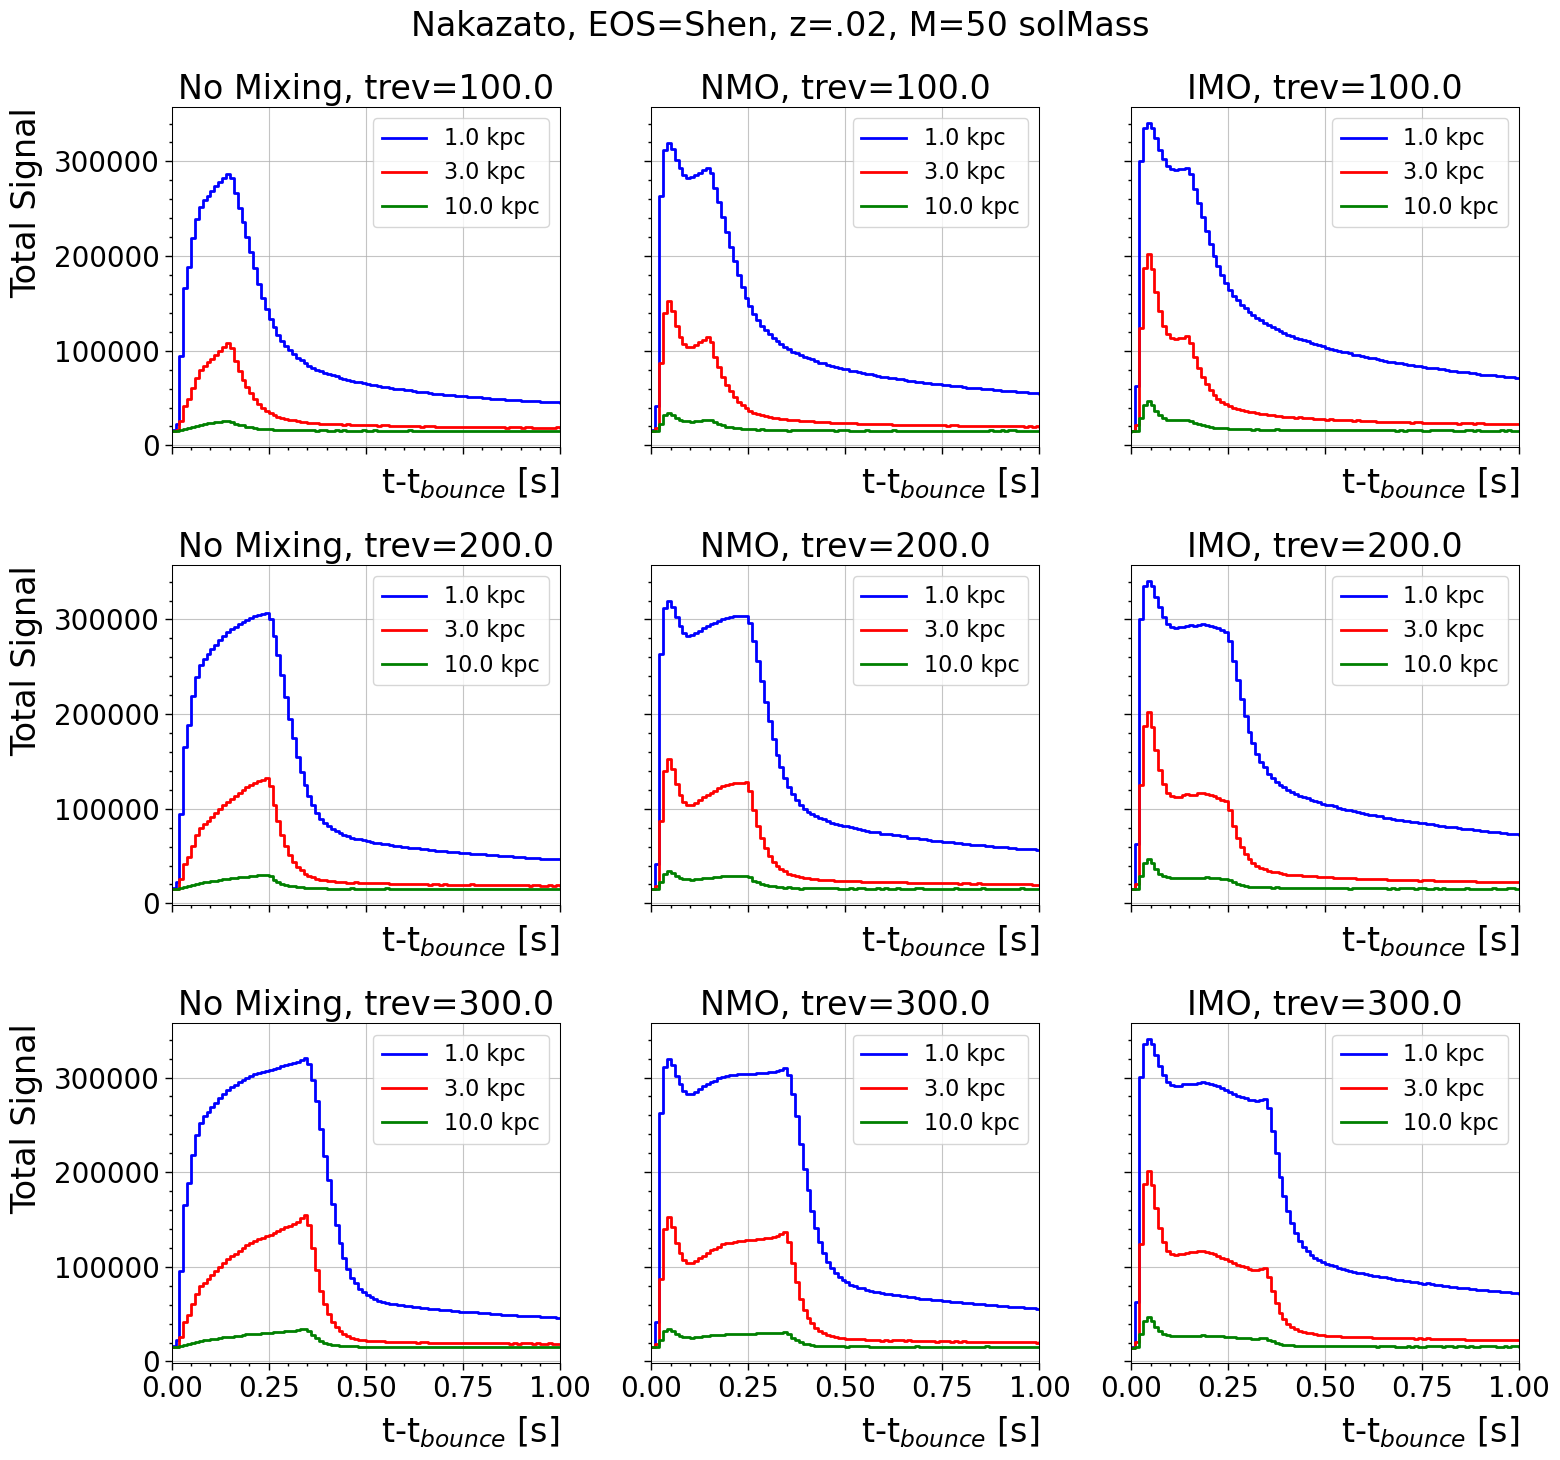

In [104]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
fig, axes = plt.subplots(3,3, figsize=(16,15), sharex=True, sharey=True, tight_layout=True)
dt = 0.01 * u.s
colors=['blue','red','green','orange']
distances=[1*u.kpc,3*u.kpc,10*u.kpc]

for k,mods in enumerate([z2_t100_mods,z2_t200_mods,z2_t300_mods]):
    for i in range(np.shape(mods)[0]):
        ax=axes[k,i]
        for j,dist in enumerate(distances):
            simm=mods[i,3]
            simm.scale_result(dist)
            simm.rebin_result(dt)
            t, hits = simm.detector_signal(dt)
            bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
            ax.step(t, hits+bg, where='post', label=dist, lw=2,color=colors[j])
        ax.legend()
        ax.set(xlim=(0, 1),xlabel=r'$E$ [{}]'.format(energies.unit),
            title=('No Mixing, trev={}'.format(models2[k][j]['revival_time'].value) if i==0 
                    else ('NMO, trev={}'.format(models2[k][j]['revival_time'].value) if i==1 
                        else 'IMO, trev={}'.format(models2[k][j]['revival_time'].value))))
        ax.set_xlabel(r't-t$_{bounce}$ [s]')
    axes[k,0].set_ylabel(fr'Total Signal')

fig.suptitle('Nakazato, EOS=Shen, z=.02, M=50 solMass')

In [149]:
mods_sukh=[[],[],[]]
labels=['normal','nmo','imo']
for j,simm in enumerate([sim, sim_n,sim_i]):
    for k,mod in enumerate(sukh_models):
        with open("Sukhbold_eos={}_M={}_mix={}.pkl".format(mod['eos'], 
                                                                         mod['progenitor_mass'].value,
                                                                         labels[j]), 'rb') as f:
            simm=pickle.load(f)
        mods_sukh[j].append(simm)
mods_sukh=np.array(mods_sukh)

In [167]:
sukh_models

[{'progenitor_mass': <Quantity 27. solMass>, 'eos': 'LS220'},
 {'progenitor_mass': <Quantity 27. solMass>, 'eos': 'SFHo'},
 {'progenitor_mass': <Quantity 9.6 solMass>, 'eos': 'LS220'},
 {'progenitor_mass': <Quantity 9.6 solMass>, 'eos': 'SFHo'}]

In [158]:
mass

[<Quantity 9. solMass>,
 <Quantity 12.54 solMass>,
 <Quantity 14.01 solMass>,
 <Quantity 18.04 solMass>]

Text(0.5, 0.98, 'Sukhbold')

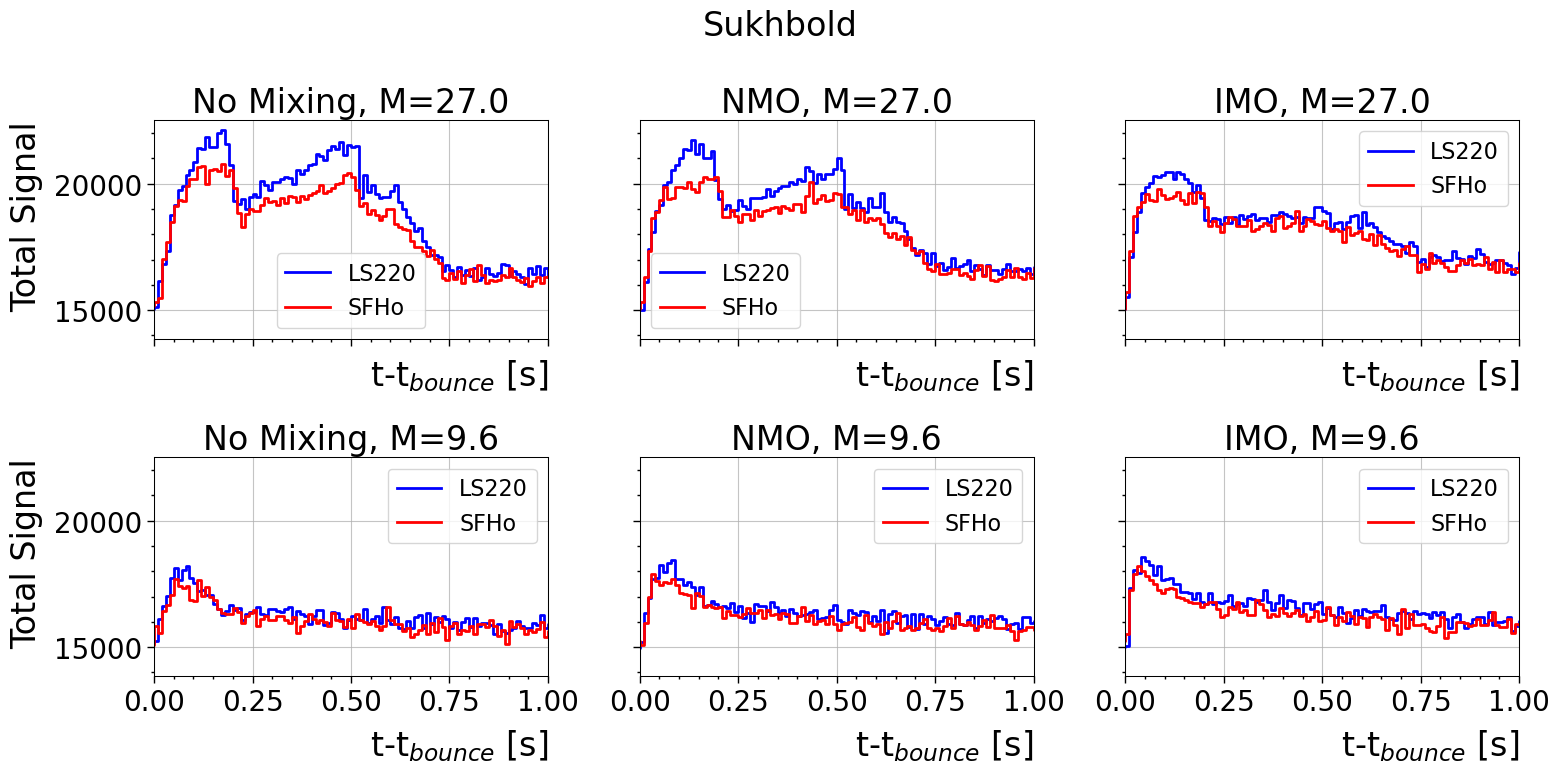

In [150]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
fig, axes = plt.subplots(2,3, figsize=(16,8), sharex=True, sharey=True, tight_layout=True)
dt = 0.01 * u.s
colors=['blue','red','green','orange']
distances=[1*u.kpc,3*u.kpc,10*u.kpc]
eoss=['LS220','SFHo']

for k in range(2):
    for i in range(3):
        ax=axes[k,i]
        for j,eos in enumerate(eoss):
            if(k==0):
                l=j
            else:
                l=j+2
            simm=mods_sukh[i,l]
            #simm.scale_result(dist)
            simm.rebin_result(dt)
            t, hits = simm.detector_signal(dt)
            bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
            ax.step(t, hits+bg, where='post', label=eos, lw=2,color=colors[j])
        ax.legend()
        ax.set(xlim=(0, 1),xlabel=r'$E$ [{}]'.format(energies.unit),
            title=('No Mixing, M={}'.format(sukh_models[l]['progenitor_mass'].value) if i==0 
                    else ('NMO, M={}'.format(sukh_models[l]['progenitor_mass'].value) if i==1 
                        else 'IMO, M={}'.format(sukh_models[l]['progenitor_mass'].value))))
        ax.set_xlabel(r't-t$_{bounce}$ [s]')
    axes[k,0].set_ylabel(fr'Total Signal')

fig.suptitle('Sukhbold')

Text(0.5, 0.98, 'Sukhbold')

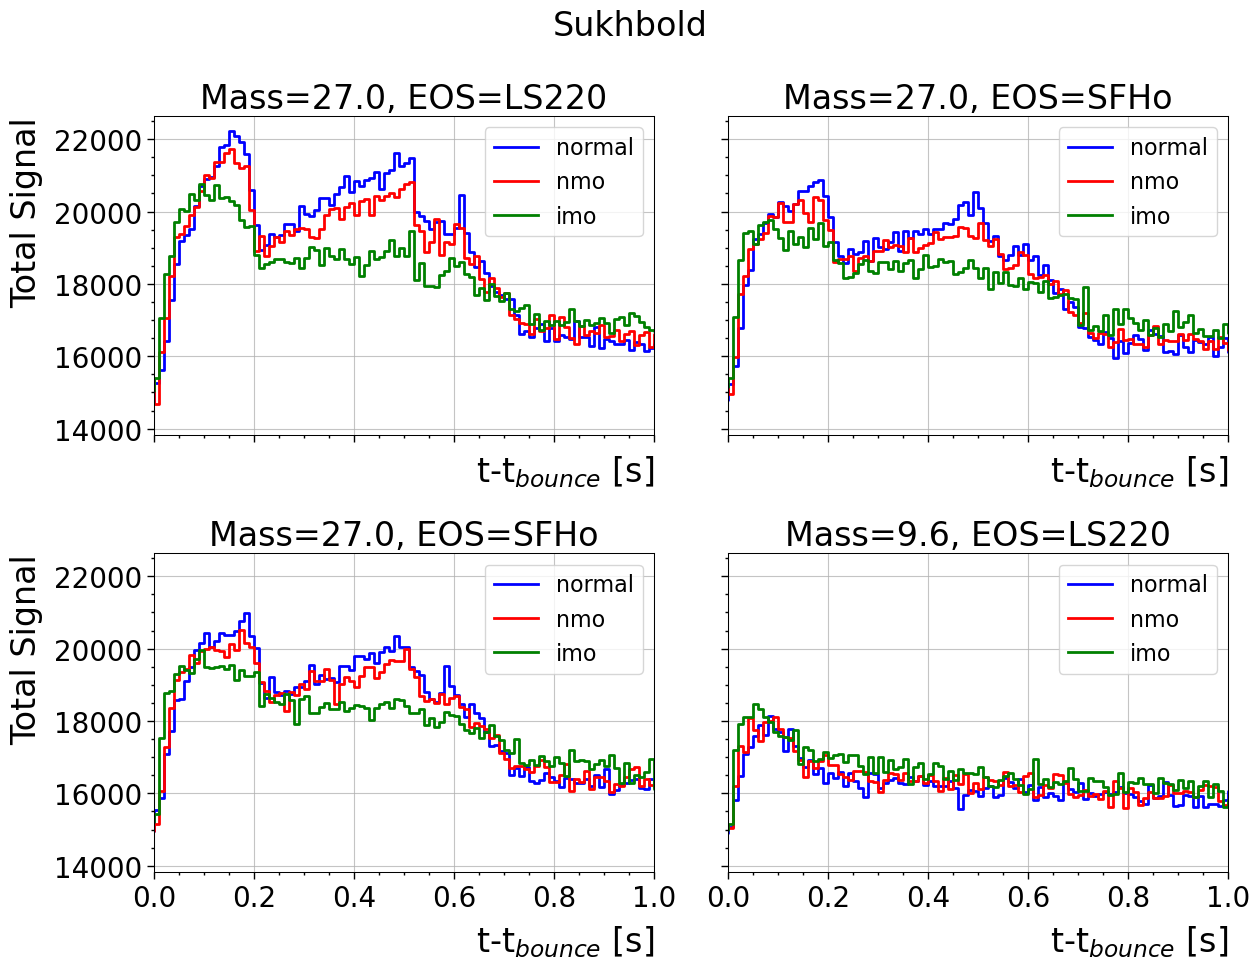

In [180]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
fig, axes = plt.subplots(2,2, figsize=(13,10), sharex=True, sharey=True, tight_layout=True)
dt = 0.01 * u.s
colors=['blue','red','green','orange']
distances=[1*u.kpc,3*u.kpc,10*u.kpc]
eoss=['LS220','SFHo']

for k in range(2):
    for i in range(2):
        ax=axes[k,i]
        for j,label in enumerate(labels):
            simm=mods_sukh[j,k+i]
            #simm.scale_result(dist)
            simm.rebin_result(dt)
            t, hits = simm.detector_signal(dt)
            bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
            ax.step(t, hits+bg, where='post', label=label, lw=2,color=colors[j])
        ax.legend()
        m=sukh_models[k+i]['progenitor_mass'].value
        eos=sukh_models[k+i]['eos']
        ax.set(xlim=(0, 1),xlabel=r'$E$ [{}]'.format(energies.unit), title=('Mass={}, EOS={}'.format(m,eos)))
        ax.set_xlabel(r't-t$_{bounce}$ [s]')
    axes[k,0].set_ylabel(fr'Total Signal')

fig.suptitle('Sukhbold')

Text(0.5, 0.98, 'Sukhbold, EOS=SFHo, M=27 solMass')

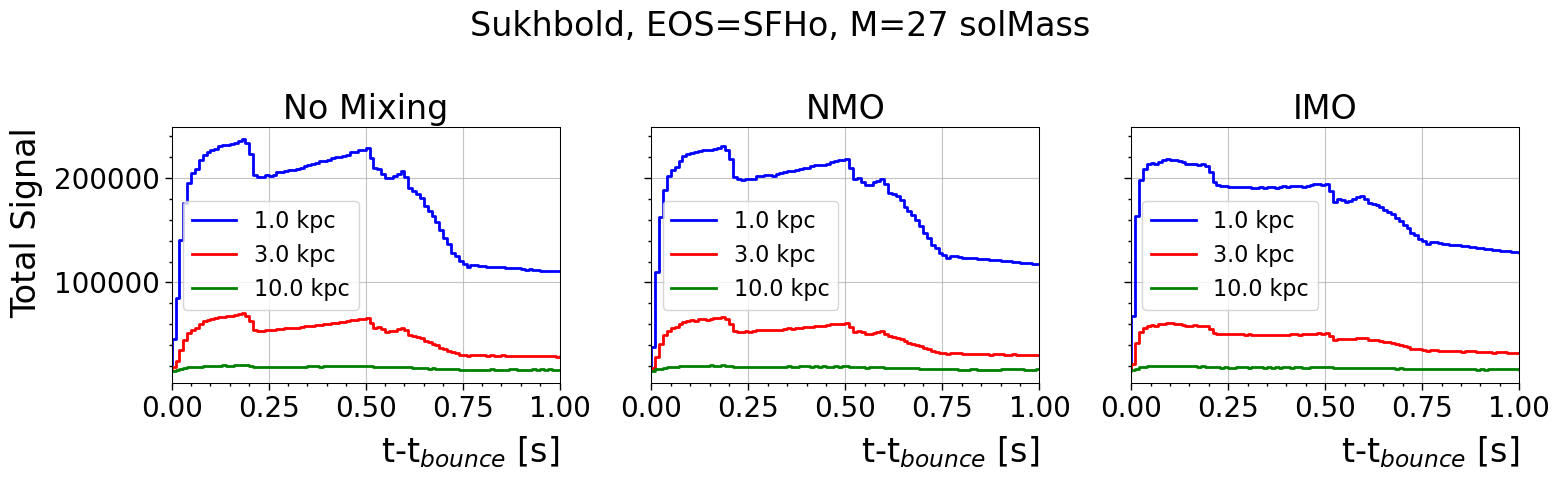

In [151]:
fig, axes = plt.subplots(1,3, figsize=(16,5), sharex=True, sharey=True, tight_layout=True)
dt = 0.01 * u.s
colors=['blue','red','green','orange']
distances=[1*u.kpc,3*u.kpc,10*u.kpc]


for i in range(3):
    ax=axes[i]
    for j,dist in enumerate(distances):
        simm=mods_sukh[i,1]
        simm.scale_result(dist)
        simm.rebin_result(dt)
        t, hits = simm.detector_signal(dt)
        bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
        ax.step(t, hits+bg, where='post', label=dist, lw=2,color=colors[j])
    ax.legend()
    ax.set(xlim=(0, 1),xlabel=r'$E$ [{}]'.format(energies.unit),
            title=('No Mixing'.format(sukh_models[l]['progenitor_mass'].value) if i==0 
                    else ('NMO'.format(sukh_models[l]['progenitor_mass'].value) if i==1 
                        else 'IMO'.format(sukh_models[l]['progenitor_mass'].value))))
    ax.set_xlabel(r't-t$_{bounce}$ [s]')
axes[0].set_ylabel(fr'Total Signal')

fig.suptitle('Sukhbold, EOS=SFHo, M=27 solMass')

In [157]:
forn_models

[{'progenitor_mass': <Quantity 9. solMass>},
 {'progenitor_mass': <Quantity 12.54 solMass>},
 {'progenitor_mass': <Quantity 14.01 solMass>},
 {'progenitor_mass': <Quantity 18.04 solMass>}]

In [153]:
labels=['normal','nmo','imo']
mods_forn=[[],[],[]]
for i,modd in enumerate(forn_models):
    for j,simm in enumerate([sim, sim_n,sim_i]): 
        with open("Fornax_M={}_mix={}.pkl".format(forn_models[i]['progenitor_mass'].value,
                                                                     labels[j]), 'rb') as f:
            mod=pickle.load(f)
        mods_forn[j].append(mod)
mods_forn=np.array(mods_forn)

Text(0.5, 0.98, 'Fornax2022')

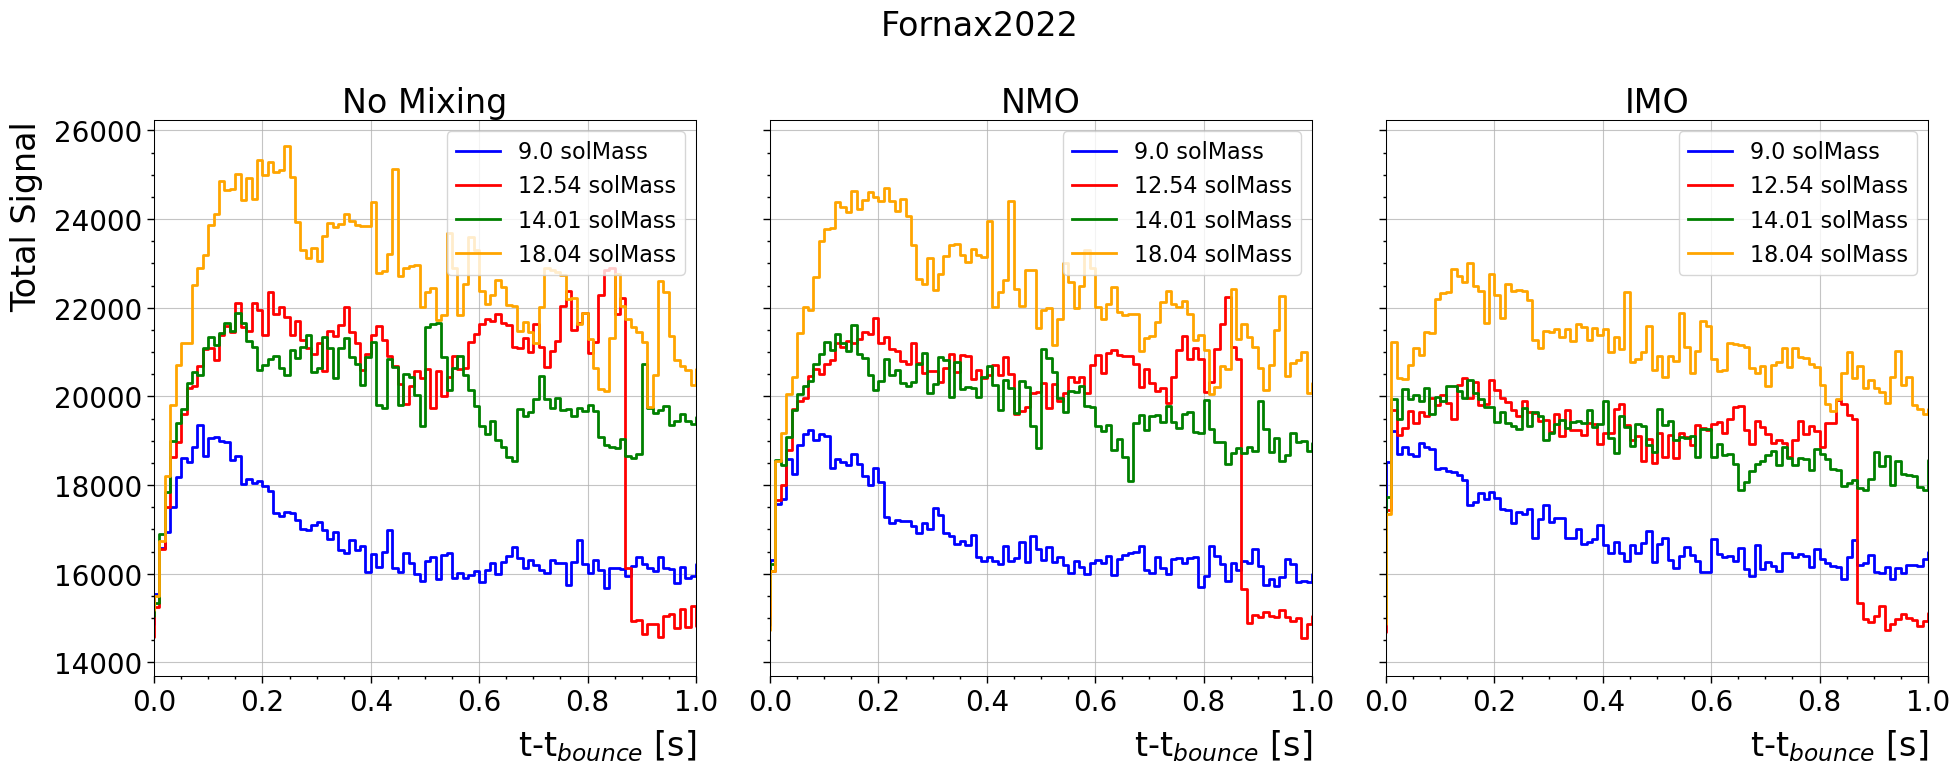

In [160]:
fig, axes = plt.subplots(1,3, figsize=(20,8), sharex=True, sharey=True, tight_layout=True)
dt = 0.01 * u.s
colors=['blue','red','green','orange']
distances=[1*u.kpc,3*u.kpc,10*u.kpc]

for i in range(3):
    ax=axes[i]
    for j,m in enumerate(mass):
        simm=mods_forn[i,j]
        #simm.scale_result(dist)
        simm.rebin_result(dt)
        t, hits = simm.detector_signal(dt)
        bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
        ax.step(t, hits+bg, where='post', label=m, lw=2,color=colors[j])
    ax.legend()
    ax.set(xlim=(0, 1),xlabel=r'$E$ [{}]'.format(energies.unit),
            title=('No Mixing' if i==0 
                    else ('NMO' if i==1 
                        else 'IMO')))
    ax.set_xlabel(r't-t$_{bounce}$ [s]')
axes[0].set_ylabel(fr'Total Signal')

fig.suptitle('Fornax2022')

In [181]:
mods_forn

array([[<asteria.simulation.Simulation object at 0x0000020306C487F0>,
      dtype=object)

In [184]:
help(model)

Help on Nakazato_2013 in module snewpy.models.ccsn object:

class Nakazato_2013(Nakazato_2013)
 |  Nakazato_2013(filename: str = None, progenitor_mass: astropy.units.quantity.Quantity = None, revival_time: astropy.units.quantity.Quantity = None, metallicity: float = None, eos: str = None)
 |  
 |  Model based on simulations from Nakazato et al., ApJ S 205:2
 |  (2013), ApJ 804:75 (2015), PASJ 73:639 (2021). See also http://asphwww.ph.noda.tus.ac.jp/snn/.
 |  
 |  Method resolution order:
 |      Nakazato_2013
 |      Nakazato_2013
 |      Nakazato_2013
 |      snewpy.models.ccsn_loaders.Nakazato_2013
 |      snewpy.models.base.PinchedModel
 |      snewpy.models.base.SupernovaModel
 |      abc.ABC
 |      snewpy._model_downloader.RegistryFileLoader
 |      snewpy._model_downloader.LocalFileLoader
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filename: str = None, progenitor_mass: astropy.units.quantity.Quantity = None, revival_time: astropy.units.quantit

Text(0.5, 0.98, 'Fornax2022')

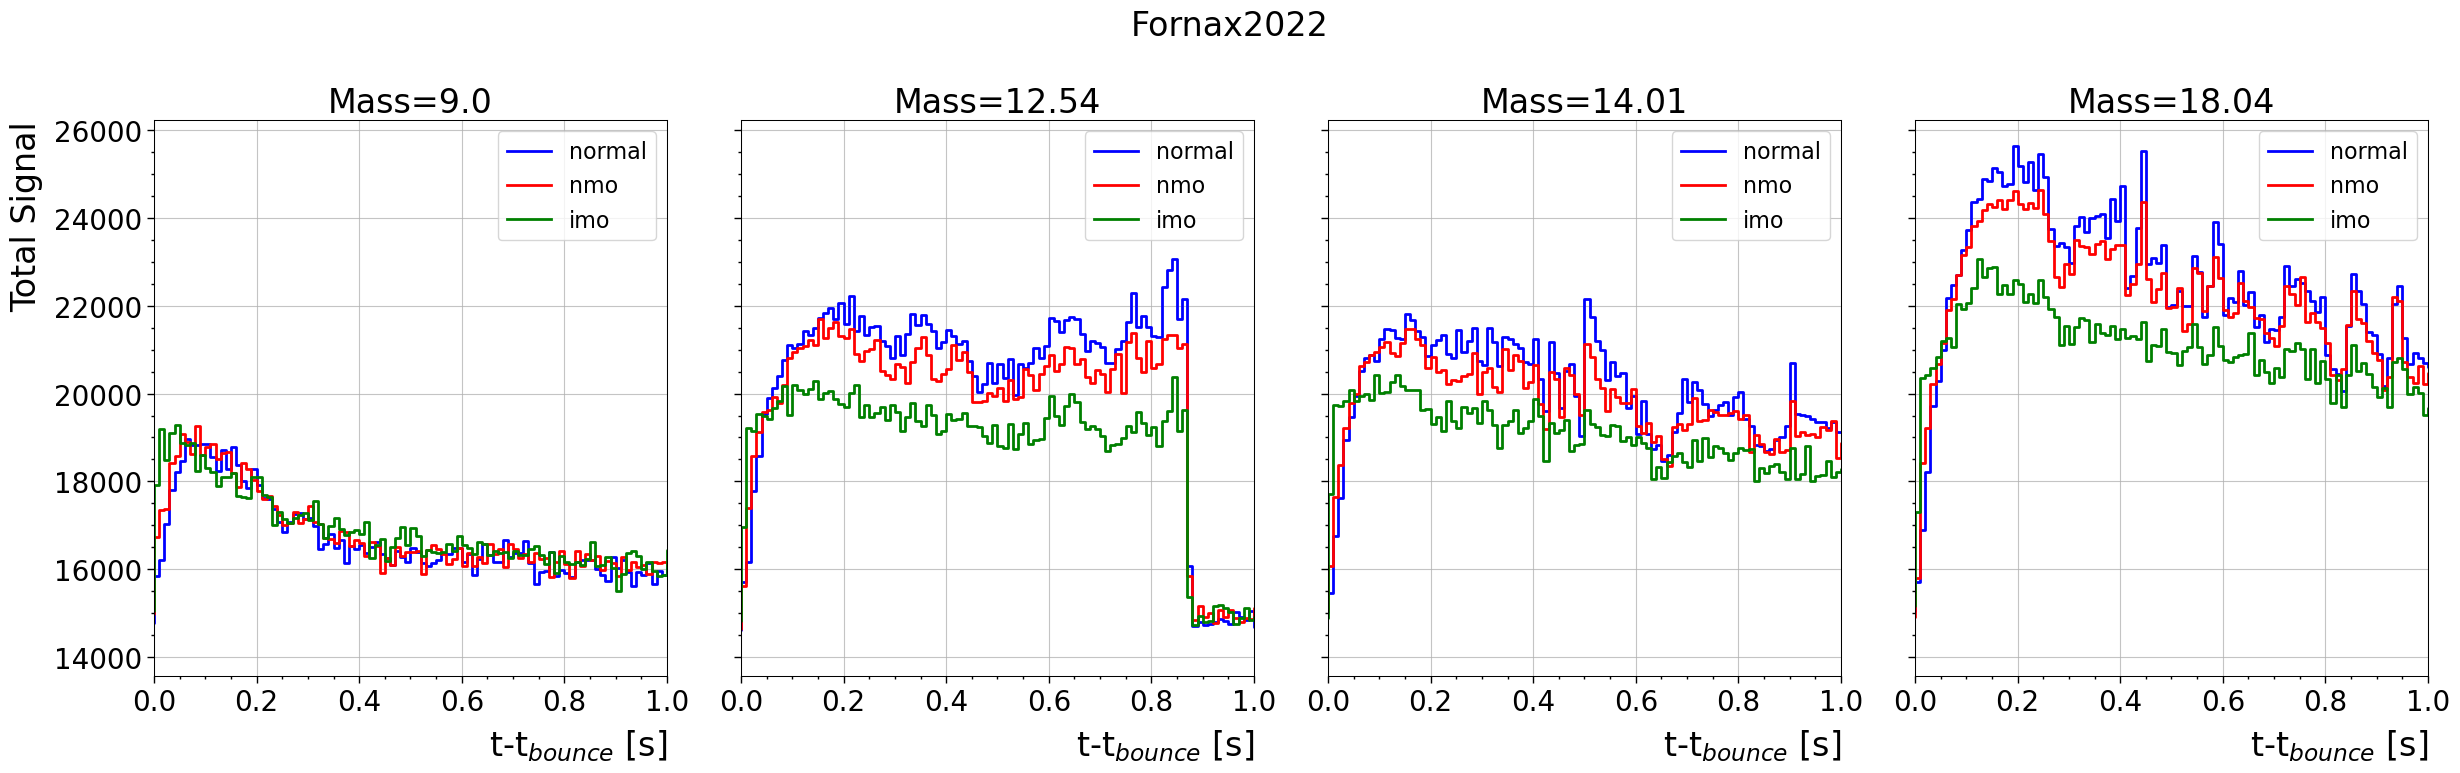

In [183]:
fig, axes = plt.subplots(1,4, figsize=(25,8), sharex=True, sharey=True, tight_layout=True)
dt = 0.01 * u.s
colors=['blue','red','green','orange']
distances=[1*u.kpc,3*u.kpc,10*u.kpc]

for i in range(4):
    ax=axes[i]
    for j,lab in enumerate(labels):
        simm=mods_forn[j,i]
        #simm.scale_result(dist)
        simm.rebin_result(dt)
        t, hits = simm.detector_signal(dt)
        bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
        ax.step(t, hits+bg, where='post', label=lab, lw=2,color=colors[j])
    ax.legend()
    ax.set(xlim=(0, 1),xlabel=r'$E$ [{}]'.format(energies.unit),
            title=('Mass={}'.format(forn_models[i]['progenitor_mass'].value)))
    ax.set_xlabel(r't-t$_{bounce}$ [s]')
axes[0].set_ylabel(fr'Total Signal')

fig.suptitle('Fornax2022')

Text(0, 1, 'Total Signal')

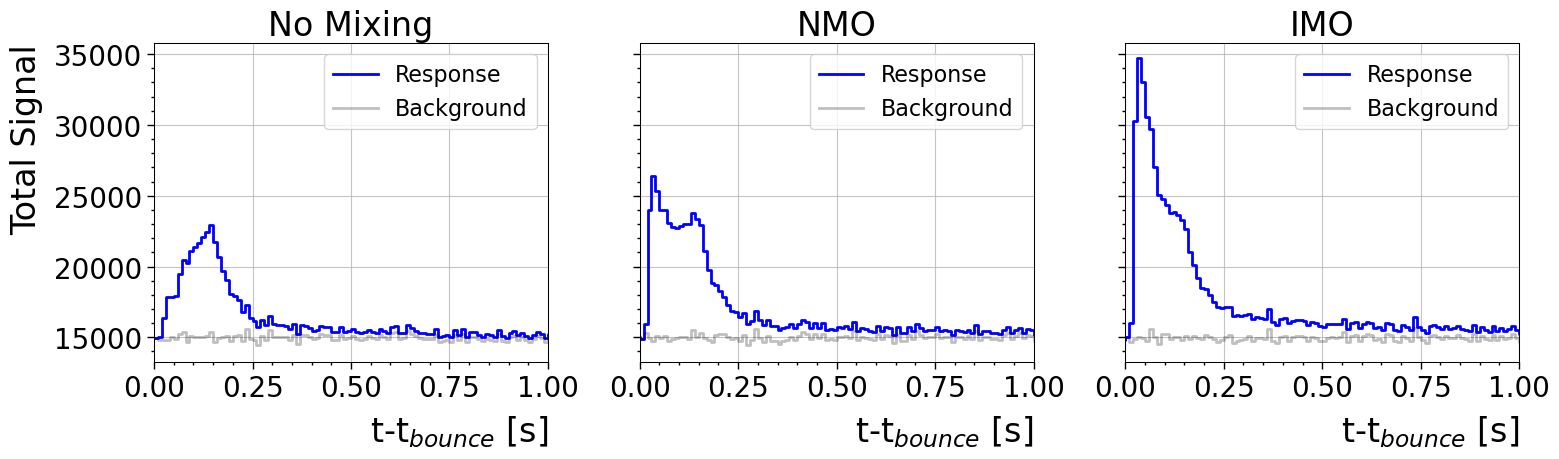

In [32]:
fig, axes = plt.subplots(1,3, figsize=(16,5), sharex=True, sharey=True, tight_layout=True)
dt = 0.01 * u.s
colors=['blue','red','green','orange']
distances=[1*u.kpc,3*u.kpc,10*u.kpc]


for i in range(3):
    ax=axes[i]
    for j,dist in enumerate(distances):
        simm=mods[i,1]
        simm.scale_result(dist)
        simm.rebin_result(dt)
        t, hits = simm.detector_signal(dt)
        bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
        ax.step(t, hits+bg, where='post', label=dist, lw=2,color=colors[j])
    ax.legend()
    ax.set(xlim=(0, 1),xlabel=r'$E$ [{}]'.format(energies.unit),
            title=('No Mixing'.format(sukh_models[l]['progenitor_mass'].value) if i==0 
                    else ('NMO'.format(sukh_models[l]['progenitor_mass'].value) if i==1 
                        else 'IMO'.format(sukh_models[l]['progenitor_mass'].value))))
    ax.set_xlabel(r't-t$_{bounce}$ [s]')
axes[0].set_ylabel(fr'Total Signal')

fig.suptitle('Sukhbold, EOS=SFHo, M=27 solMass')

Text(0, 1, 'Signal per DOM')

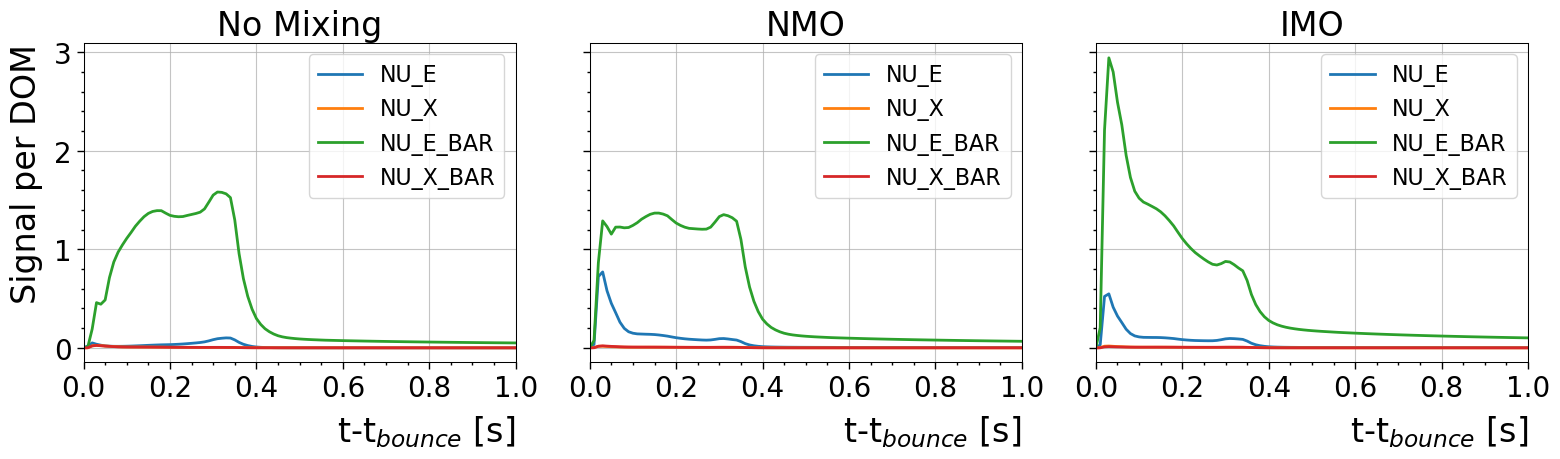

In [49]:
fig, axes = plt.subplots(1,3, figsize=(16,5), sharex=True, sharey=True, tight_layout=True)
dt = 0.01 * u.s

for i,simm in enumerate([sim, sim_n,sim_i]):
    ax=axes[i]
    simm.rebin_result(dt)
    t, hits = simm.detector_signal(dt)
    for flavor in simm.flavors:
        ax.plot(t, simm.avg_dom_signal(flavor=flavor), label=flavor.name)
    ax.legend()
    ax.set(xlabel=r't-t$_{bounce}$ [s]',xlim=(0,1),
          title=('No Mixing'.format(t) if i==0 
                else ('NMO'.format(t) if i==1 
                    else 'IMO'.format(t))));

axes[0].set_ylabel('Signal per DOM')


Text(43.000000000000014, 1, 'Signal per DOM')

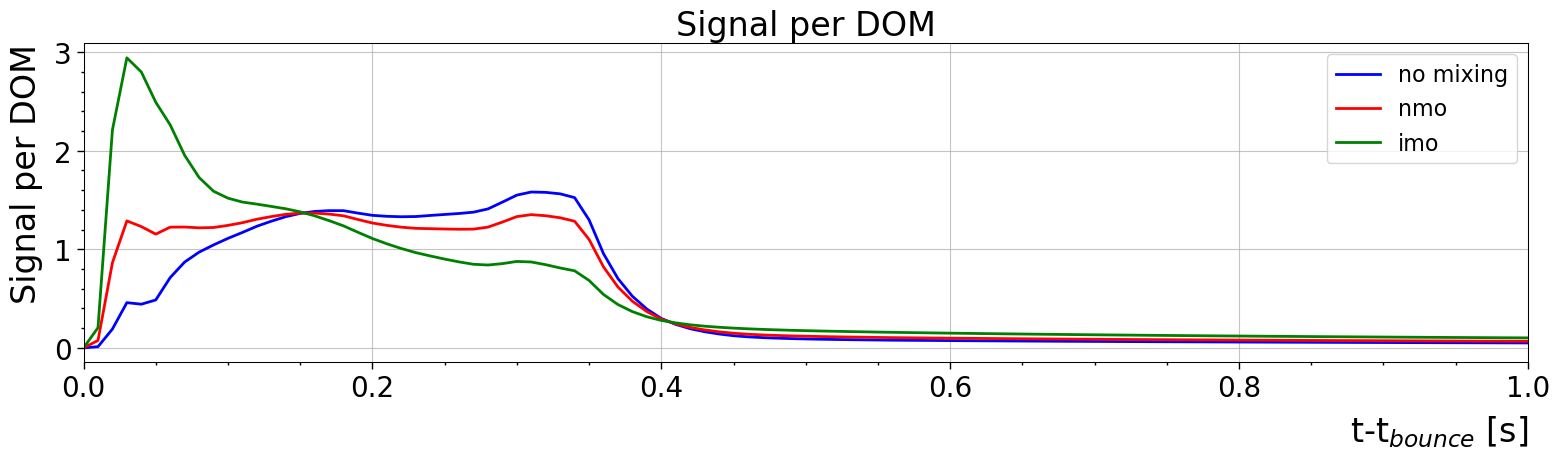

In [66]:
fig, ax = plt.subplots(1, figsize=(16,5), sharex=True, sharey=True, tight_layout=True)
dt = 0.01 * u.s
colors=['blue','red','green']
names=['no mixing','nmo','imo']
for i,simm in enumerate([sim, sim_n,sim_i]):
    simm.rebin_result(dt)
    t, hits = simm.detector_signal(dt)
    #for flavor in simm.flavors:
    ax.plot(t, simm.avg_dom_signal(flavor=Flavor(2)), label=names[i],c=colors[i])
    
ax.legend()
ax.set(xlabel=r't-t$_{bounce}$ [s]',xlim=(0,1),title='Signal per DOM',ylabel='Signal per DOM')

axes[0].set_ylabel('Signal per DOM')
